In [1]:
import numpy as np
import pandas as pd
import gensim
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

from gensim.models import word2vec
import gensim.downloader as api

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import os
import seaborn as sn
import pickle
from gensim.models import KeyedVectors


In [2]:
model = KeyedVectors.load_word2vec_format("fasttext/wiki-news-300d-1M.vec")

In [3]:
df = pd.read_csv('./HASOC/cleaned_data_train.csv')
df_test = pd.read_csv('./HASOC/cleaned_data_test.csv')
df.dropna()
df_test.dropna()
df['task1'].replace(['NOT', 'HOF'],[0, 1], inplace=True)
df_test['task1'].replace(['NOT', 'HOF'],[0, 1], inplace=True)

In [4]:
lemattized = []
for lem in df.lemattized:
    res = lem.strip('][').replace("'", '').split(', ')
    lemattized.append(res)


In [5]:
lemattized_test = []
for lem in df_test.lemattized:
    res = lem.strip('][').replace("'", '').split(', ')
    lemattized_test.append(res)


In [6]:
y_train = np.asarray(df["task1"])
y_test = np.asarray(df_test["task1"])
y_test

array([0, 1, 0, ..., 1, 1, 1])

In [7]:
all_words = [token for seq in lemattized for token in seq]
all_words
print('Review example: ', all_words[:20])
print('Label: ',y_train[0])

Review example:  ['hate', 'females', 'nigga', 'tryna', 'make', 'sweety', 'fuck', 'airjunebug', 'really', 'nigga', 'heart', 'supportcaleon', 'donaldjtrumpjr', 'dear', 'democrats', 'american', 'people', 'stupid', 'know', 'spy']
Label:  1


In [8]:
X_train = np.asarray([(" ".join(seq)) for seq in lemattized])
X_test = np.asarray([(" ".join(seq)) for seq in lemattized_test])
print(len(X_train), len(X_test))


3552 1514


In [9]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def display_closestwords_tsnescatterplot(model, dim, words):

    arr = np.empty((0, dim), dtype='f')
    word_labels = words

    # get close words
    #close_words = [model.similar_by_word(word) for word in words]

    # add the vector for each of the closest words to the array
    close_words = []
    for word in words:
        arr = np.append(arr, np.array([model[word]]), axis=0)
        close_words += model.similar_by_word(word)

    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(
            0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


def tsne_plot(model, words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    #for word in model.wv.vocab:
    for word in words:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2,
                      init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(14, 10))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


In [10]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" %
          (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)


In [11]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = y_train
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = y_test

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 21 / 3552
Numer of samples with no words found: 8 / 1514


In [12]:
print(Xtrain.shape,Xtest.shape)

(3552, 300) (1514, 300)


In [13]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred, figNumber):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                         range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, fmt='.0f',
               annot_kws={"size": 10})  # font size
    plt.ylabel('Predicted Values')
    plt.xlabel('True Values')
    plt.savefig('./confusion_matrix ' + str(figNumber) + '.jpg')
    plt.show()

# ROC Curve
# plot no skill
# Calculate the points in the ROC curve


def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [14]:
from sklearn.ensemble import RandomForestClassifier

# create the model, train it, print scores
clf = RandomForestClassifier(n_estimators=200)

clf.fit(Xtrain, Ytrain)

print("train score:", clf.score(Xtrain, Ytrain))
print("test score:", clf.score(Xtest, Ytest))


train score: 0.995777027027027
test score: 0.8500660501981506


              precision    recall  f1-score   support

           0       0.80      0.94      0.86       763
           1       0.92      0.76      0.83       751

    accuracy                           0.85      1514
   macro avg       0.86      0.85      0.85      1514
weighted avg       0.86      0.85      0.85      1514



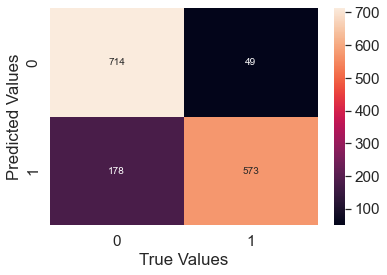

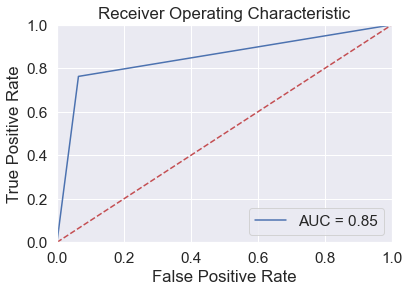

In [15]:
# Predicting the Test set results
y_pred = clf.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=2))
plot_confussion_matrix(Ytest, y_pred, 'Random Forest')
plot_roc_curve(Ytest, y_pred)


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameters to tune
parameters = {
    'C': [1.0, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters,
                     cv=5, n_jobs=-1).fit(Xtrain, Ytrain)


              precision    recall  f1-score   support

           0       0.82      0.95      0.88       763
           1       0.94      0.79      0.86       751

    accuracy                           0.87      1514
   macro avg       0.88      0.87      0.87      1514
weighted avg       0.88      0.87      0.87      1514



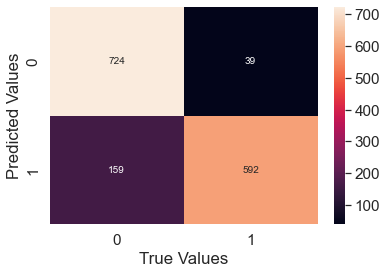

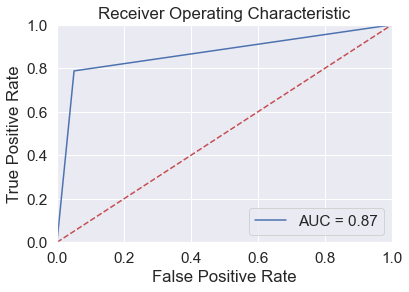

In [17]:
# Predicting the Test set results
y_pred = model.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=2))
plot_confussion_matrix(Ytest, y_pred, 'Support Vector Machine')
plot_roc_curve(Ytest, y_pred)


In [18]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB

model = GaussianNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))


train score: 0.826295045045045
test score: 0.8295904887714664


              precision    recall  f1-score   support

           0       0.76      0.96      0.85       763
           1       0.94      0.70      0.80       751

    accuracy                           0.83      1514
   macro avg       0.85      0.83      0.83      1514
weighted avg       0.85      0.83      0.83      1514



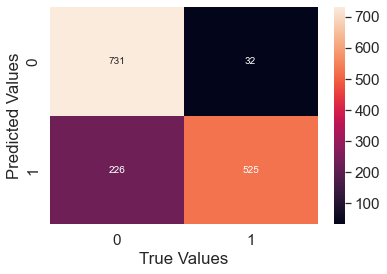

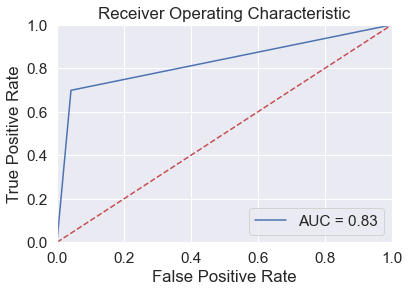

In [19]:
# Predicting the Test set results
y_pred = model.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=2))
plot_confussion_matrix(Ytest, y_pred, 'Naive Bayes')
plot_roc_curve(Ytest, y_pred)